In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

/home/nakagawaren/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

# Prediction Import

In [3]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
df = pd.read_csv('predict.csv', index_col=0)
predict = df.drop('true', axis=1)
true = df['true']
del df
true_encoded = true.map(lambda x: LABELS[x])
true_encoded.name = 'true_label'
predict.columns = LABELS
predict.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking
0,-0.051365,-6.140929,-5.497334,-5.696781,-0.642313,13.210702
1,-1.509786,-8.522696,14.942570,2.538199,-1.973984,-0.270892
2,0.835547,-7.029146,-9.856510,-3.872520,7.731555,3.101007
3,2.742987,15.359550,-0.604864,-5.680943,-6.409413,-4.199465
4,-4.779817,-3.136304,-3.719555,13.347833,0.276563,-0.086556


In [4]:
# min-max normalization
predict = predict.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
predict = predict.apply(lambda x: x / x.sum(), axis=1)

predict_label = predict.idxmax(axis=1)
predict_probability = predict.max(axis=1)
predict_probability.name = 'predict_probability'
predict_label.name = 'predict_label'
# predict.head()
# true.head()
# true_encoded.head()

In [5]:
df = pd.concat([
            predict,
            predict_probability,
            true,
            predict_label,
            true_encoded
        ], axis=1)
df.head(10)

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,true,predict_label,true_label
0,0.190135,0.000000,0.020095,0.013868,0.171684,0.604218,0.604218,5,Walking,Walking
1,0.124476,0.000000,0.416497,0.196325,0.116236,0.146465,0.416497,2,Sitting,Sitting
2,0.213632,0.056492,0.000000,0.119563,0.351417,0.258897,0.351417,4,Upstairs,Upstairs
3,0.230746,0.548830,0.146342,0.018366,0.000000,0.055716,0.548830,1,Jogging,Jogging
4,0.000000,0.053743,0.034671,0.592774,0.165343,0.153470,0.592774,3,Standing,Standing
5,0.127539,0.156200,0.000000,0.051001,0.126032,0.539227,0.539227,5,Walking,Walking
6,0.462734,0.053127,0.000000,0.094852,0.231168,0.158119,0.462734,0,Downstairs,Downstairs
7,0.321177,0.000000,0.058668,0.141444,0.244021,0.234690,0.321177,0,Downstairs,Downstairs
8,0.145536,0.648344,0.012371,0.000000,0.126813,0.066936,0.648344,1,Jogging,Jogging
9,0.164850,0.103405,0.000000,0.049451,0.085157,0.597137,0.597137,5,Walking,Walking


Accuracy:  0.9467038970498968


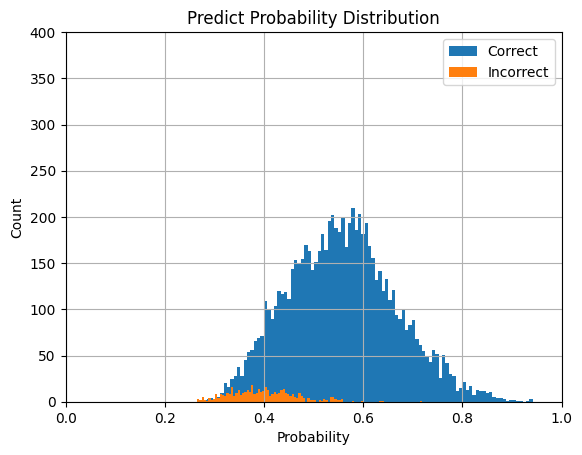

In [6]:
print('Accuracy: ', calc_accuracy(df))
# statival analysis
df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100)
plt.title('Predict Probability Distribution')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [7]:
df['predict_probability'].agg(['mean', 'std', 'min', 'max', 'median'])

mean      0.548423
std       0.112778
min       0.264036
max       0.941894
median    0.546834
Name: predict_probability, dtype: float64

In [8]:
thresholds = [0, 0.3, 0.4, 0.5, 0.6, 0.7]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
    # cm = confusion_matrix(df_confidence['true_label'], df_confidence['predict_label'])
    # cm_df = pd.DataFrame(cm, index=LABELS, columns=LABELS)
    # plt.figure(figsize=(10, 10))
    # sns.heatmap(
    #     cm_df,
    #     annot=True,
    #     fmt="d",
    #     linewidths=0.5,
    #     cmap="Blues",
    #     cbar=False,
    #     annot_kws={"size": 14},
    #     square=True,
    # )
    # plt.title(f"Confusion Matrix (threshold={threshold})")
    # plt.ylabel("True label")
    # plt.xlabel("Predicted label")
    # plt.savefig(f'confusion_matrix/threshold{threshold}.png')
    # plt.close()
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_13608/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.0,0.946704,1.000000,0.000000,0.000000
0.3,0.949043,0.995872,0.382353,0.004128
0.4,0.972882,0.904334,0.699239,0.095666
0.5,0.993493,0.653029,0.858642,0.346971
0.6,0.998856,0.318441,0.922337,0.681559
0.7,0.998731,0.095666,0.941200,0.904334


/home/nakagawaren/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


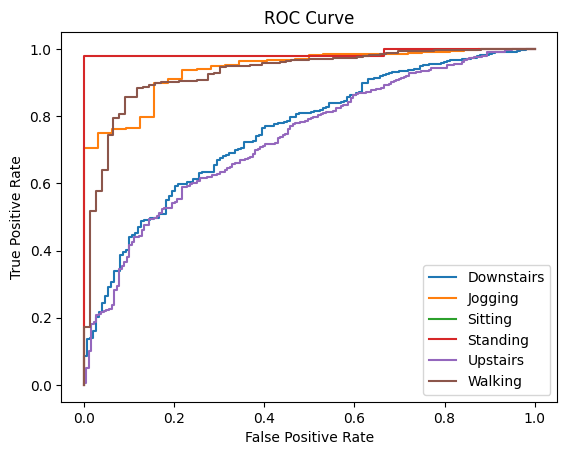

In [9]:
from sklearn.metrics import roc_curve

for label in LABELS:
    fpr, tpr, thresholds = roc_curve(df.loc[df.predict_label==label, 'true_label'], df.loc[df.predict_label==label, "predict_probability"], pos_label=label)
    plt.plot(fpr, tpr, label=label)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Each Label Prediction Probability of histgram

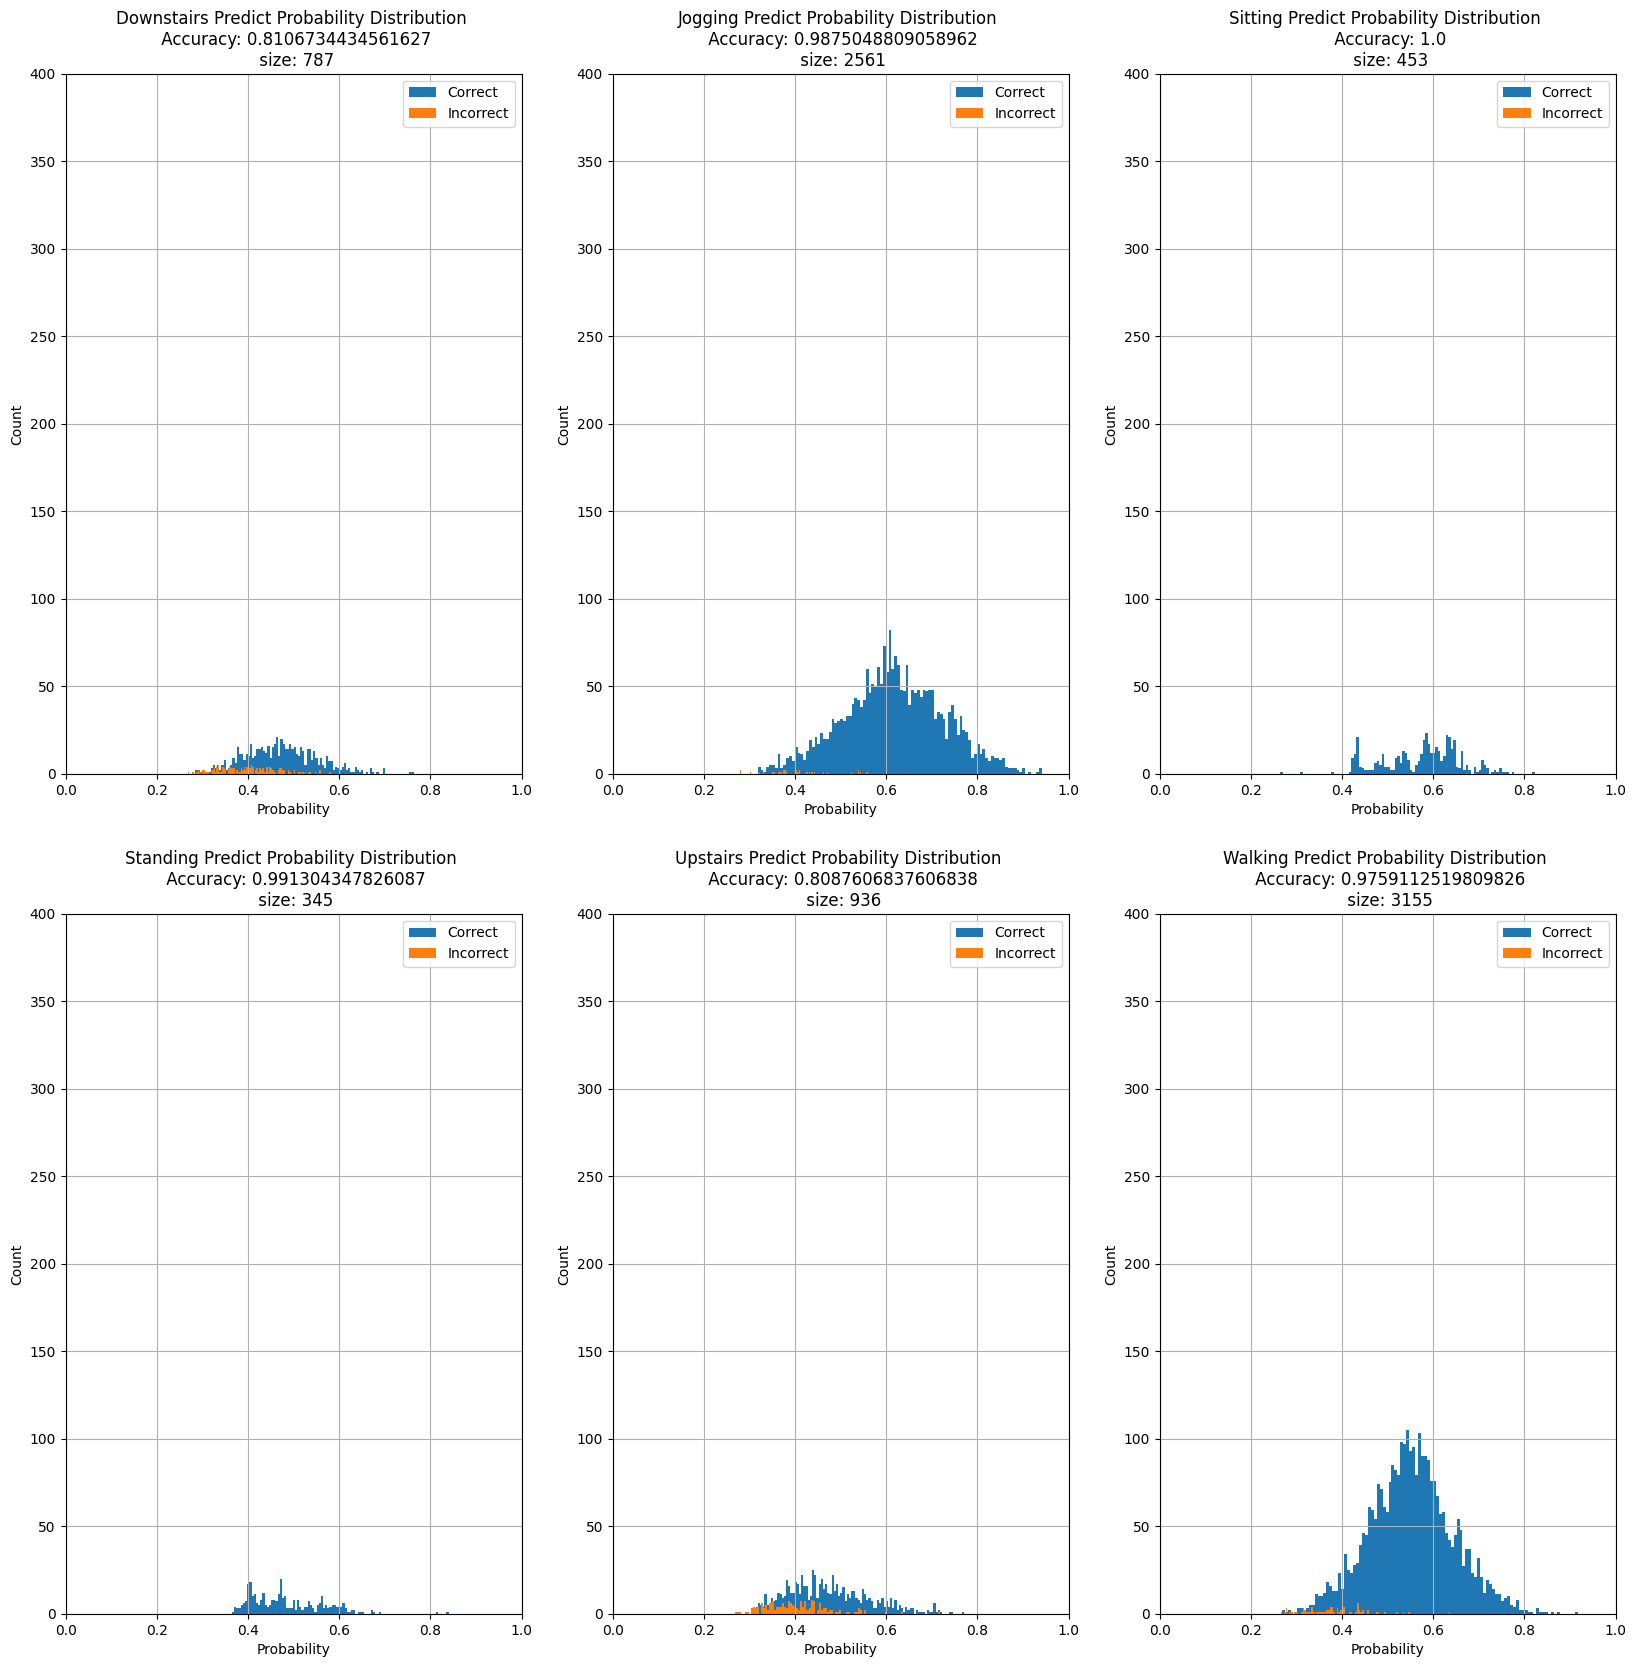

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(20, 20))

for i, label in enumerate(LABELS):
    df_label = df.loc[df.predict_label==label, :]
    df_label.loc[df_label.true_label==df_label.predict_label, 'predict_probability'].hist(bins=100, ax=axs[i//3][i%3])
    df_label.loc[df_label.true_label!=df_label.predict_label, 'predict_probability'].hist(bins=100, ax=axs[i//3][i%3])
    axs[i//3][i%3].set_title(f"{label} Predict Probability Distribution \n Accuracy: {calc_accuracy(df_label)}\n size: {len(df_label)}")
    axs[i//3][i%3].set_xlim(0, 1)
    axs[i//3][i%3].set_ylim(0, 400)
    axs[i//3][i%3].set_xlabel('Probability')
    axs[i//3][i%3].set_ylabel('Count')
    axs[i//3][i%3].legend(['Correct', 'Incorrect'])
# plt.tight_layout()
plt.show()